<font color="">**ENG5337: Advanced Machine**</font>  
<font color="">**Transfer Learning in Computer Vision**</font>  
<font color="">**Lecturer**</font>&nbsp; <font color="DeepSkyBlue">*Khiem Nguyen*</font> - *James Watt School of Engeering  University of Glasgow*

# Transfer learning in Computer Vision

In this notebook, we will learn how to train a *convolutional neural network* for image classification using <font style="color:magenta">transfer learning</font>. An excellent source of explanation can be found in [CS231n Convolution Neural Networks for Visual Recognition](https://cs231n.github.io/transfer-learning/). The following is a quote from this note:

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest. The three major Transfer Learning scenarios look as follows:
> In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

In this notebook we demonstrate two major transfer learning scenarios
- **Finetuning a ConvNet** (Convolutional Neural Network): Instead of random initialization, we initialize the network with a pretrained network, like the network that was trained on a set of images for $1000$ classes. The rest of training is done as usual.
- **ConvNet as fixed feature extractor**: In this scenario, we freeze the weights for all the modules in the network except those of the last few layers, including the fully connected layers. The last fully connected layer is replaced with a new layer with random weights and only the last few layers are trained. In many cases, we only need to freeze the weights for all the layers and modules except the last fully connected layer. In such case the training is done for the last layer (only the weights and biases in the last layer are updated.)


In [43]:
# Import packages for use
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from pathlib import Path

cudnn.benchmark = True

Note that the backend `torch.backends.cudnn` refers to the *NVIDIA CUDA Deep Neural Network* (cuDNN) is a GPU-accelerated library of primities for deep neural networks. [**cuDNN**](https://docs.nvidia.com/cudnn/index.html) provides highly tuned implementations for standard routines such as forward and backward convolution, attention, matmul, pooling and normalization. If you don't have NVIDIA GPU on your laptop or you don't want to bother complicated setup, just set `cudnn.benchmark = False` in the last line of the above cell and move on.

## Retrieve data and load data into data loader

We will use torchvision and torch.utils.data packages for loading data as in the last notebook we learned in "*Deep Neural Network week*". You should download the data from Moodle in the same folder containing this notebook. 

**<u>Problem description**</u>

We are given a set of images of *ants* and *bees*. We have about $120$ training examples each for ants and bees. That implies $240$ images for the training set, which is not a lot. There are $75$ images for validation for each class. Clearly, this is a very small dataset to make generalization, if trained from stracth. For this reason, training from scratch will likely give very bad prediction power. Transfer learning is based on the assumption that each layer in each convolution neural network builds more and more complex image features throughout the depth of the network. For example, the first layer is responsible for detecting edges, the 4th or 5th layer detects certain pattern and so on. Therefore, a pretrained, deep convolution neural network will be a good model for training on a small dataset because the training has already inherited good capabilities of the pretrained model. The new training on the last few layers or one single last layer will just help the model to recognize a new and relatively small dataset. In fact, this dataset is a very small submit of *imagenet*.

**Transformation**
We shall need to do augment the images to enrich the size of the dataset and thus give the model more training examples to "look at". Moreover, the pretrained model has applied a feature normalization through each channel of an RGB image. Therefore, we need to apply the normalization on the image before it can be fed into the model.

The following code snippet used the following transformations that have been implemented nicely in PyTorch

- [Random resized Crop of images](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html)
- [Random horizontal flip](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html)
- [To Tensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)
- [Normlize](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)

I strongly recommend you to click every single link to read the documentation and see the examples in the documentation. It is often useful to understand what you are using as it helps you to reinforce cognitive memory.

In [44]:
# Data augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Just normalization for validation
valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

print(f"train_transforms =\n{train_transform}")
print(f"valid_transforms =\n{valid_transform}")

train_transforms =
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
valid_transforms =
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [45]:
data_dir = './hymenoptera_data'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'val')
print(f"train_dir = {train_dir}")
print(f"valid_dir = {valid_dir}")

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)      # you can use './hymenoptera_data/train' and it works the same
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transform)

print(f"train_dataset =\n{train_dataset}")
print(80*"=")
print(f"valid_dataset =\n{valid_dataset}")

class_names = train_dataset.classes

train_dir = ./hymenoptera_data\train
valid_dir = ./hymenoptera_data\val
train_dataset =
Dataset ImageFolder
    Number of datapoints: 244
    Root location: ./hymenoptera_data\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
valid_dataset =
Dataset ImageFolder
    Number of datapoints: 153
    Root location: ./hymenoptera_data\val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


As many Jupyter Notebook done before, we wrap around the data with a `DataLoader`. Moreover, we set the number of workers to $4$, meaning that $4$ processors will load the batches in parallel.

In [62]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
print(f"train_dataloader = {train_dataloader}")
print(f"valid_dataloader = {valid_dataloader}")

train_dataloader = <torch.utils.data.dataloader.DataLoader object at 0x000002A46FA8E5A0>
valid_dataloader = <torch.utils.data.dataloader.DataLoader object at 0x000002A410B2E5A0>


In [63]:
train_dataset_size = len(train_dataset)
valid_dataset_size = len(valid_dataset)
class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device for training = {device}")

print(f"train_dataset_size = {train_dataset_size}")
print(f"valid_dataset_size = {valid_dataset_size}")

device for training = cuda:0
train_dataset_size = 244
valid_dataset_size = 153


In [64]:
# Let us study the structure of the dataset by looking at some examples in the dataset
for idx in [0, 100, 150]:
    print(f"index = {idx}:")
    print(f"type(image_datasets['train'][{idx}]) = {type(train_dataset[idx])}")
    print(f"image_datasets['train'][{idx}][0].shape = {train_dataset[idx][0].shape}")
    print(f"image_datasets['train'][{idx}][1] = {train_dataset[idx][1]}")

index = 0:
type(image_datasets['train'][0]) = <class 'tuple'>
image_datasets['train'][0][0].shape = torch.Size([3, 224, 224])
image_datasets['train'][0][1] = 0
index = 100:
type(image_datasets['train'][100]) = <class 'tuple'>
image_datasets['train'][100][0].shape = torch.Size([3, 224, 224])
image_datasets['train'][100][1] = 0
index = 150:
type(image_datasets['train'][150]) = <class 'tuple'>
image_datasets['train'][150][0].shape = torch.Size([3, 224, 224])
image_datasets['train'][150][1] = 1


### Visualization of images

It is good to examine the images that we are dealing with. Now, it is important to recall that we have load the images and performed random crop and horizontal flip on the images before making the final normalization step. Therefore, what we see here won't be the original photos in the folder we downloaded. Moreover, since we have normalized the images through three channels using the mean and the standard devision as follows
$$
\widetilde{\mathbf{x}} = \frac{\mathbf{x} - \boldsymbol{\mu}}{\boldsymbol{\sigma}}, \quad \text{with}\quad \boldsymbol{\mu} = (0.485, 0.456, 0.406), \quad \boldsymbol{\sigma} = (0.229, 0.224, 0.225)
$$
So, the original photo $\mathbf{x}$ is retried as
$$
\mathbf{x} = \boldsymbol{\sigma} \widetilde{\mathbf{x}} + \boldsymbol{\mu}.
$$
This formulation is reflected in the function `convert_tensor_to_image()`.

In [65]:
def convert_tensor_to_image(input):
    """
    Receive an example from the dataset in the tensor format, 
    turn the tensor into NumPy in the (num_channels, width, height) format.
    """
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    output = std * input + mean
    output = np.clip(output, 0, 1)

    return output

We shall visualize a batch of images.

In [66]:
X_batch, y_batch = next(iter(train_dataloader))
X_batch_size = len(X_batch)

print(f"X_batch.shape = {X_batch.shape}")
print(f"y_batch = {y_batch.shape}")
print(f"X_batch[0].shape = {X_batch[0].shape}")
print(f"y_batch[0] = {y_batch[0]}")

X_batch.shape = torch.Size([64, 3, 224, 224])
y_batch = torch.Size([64])
X_batch[0].shape = torch.Size([3, 224, 224])
y_batch[0] = 0


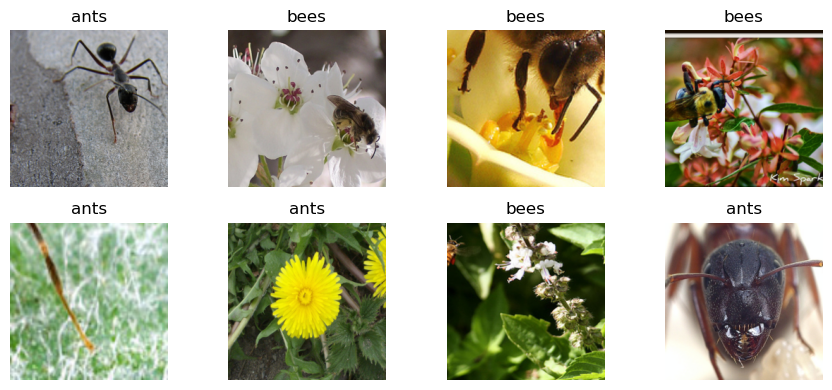

In [68]:
nrows, ncols = 2, 4
plt.figure(figsize=(9, 4))
for i in range(nrows * ncols):
    img = convert_tensor_to_image(X_batch[i])
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{class_names[y_batch[i]]}")
plt.tight_layout()

### Load a pretrained convolution neural network.

We will load the well-known convolution neural network **ResNet18**. This is a convolution neural network with $18$ layers and accept RGB image of size $(224, 224)$ as the input images. The architecture of the model is very complex and lengthy to write down. Therefore, I output the architecture into a text "txt" file. You should really have a look at the text file to see what it looks like.

In [69]:
# Let us load the pretrained model and reset final fully connected layer
model_A = models.resnet18(weights='IMAGENET1K_V1')
f = open("./resnet18-architecture.txt", "w")
f.write(90*"=" + "\n" + f"{'RESNET-18 ARCHITECTURE':^90}" + "\n" + 90*"=" + "\n")
f.write(str(model_A) + "\n\n")
f.write(90*"=" + "\n" + f"{'BEFORE layer1':^90}" + "\n" + 90*"=" + "\n")
f.write(str(model_A.conv1) + "\n")
f.write(str(model_A.bn1) + "\n")
f.write(str(model_A.relu) + "\n")
f.write(str(model_A.maxpool) + "\n\n")
f.write(90*"=" + "\n" + f"{'resnet18.layer1':^90}" + "\n" + 90*"=" + "\n")
f.write(str(model_A.layer1) + "\n\n")
f.write(90*"=" + "\n" + f"{'resnet18.layer2':^90}" + "\n" + 90*"=" + "\n")
f.write(str(model_A.layer2) + "\n\n")
f.write(90*"=" + "\n" + f"{'resnet18.layer3':^90}" + "\n" + 90*"=" + "\n")
f.write(str(model_A.layer3) + "\n\n")
f.write(90*"=" + "\n" + f"{'resnet18.layer4':^90}" + "\n" + 90*"=" + "\n")
f.write(str(model_A.layer4) + "\n\n")
f.write(90*"=" + "\n" + f"{'AFTER layer4':^90}" + "\n" + 90*"=" + "\n")
f.write(str(model_A.avgpool) + "\n")
f.write(str(model_A.fc) + "\n")

f.close()

### Interpretation of the loaded model

Before moving on, let us try to interpret the model and see what is inside the model. I quote a part of the network as follows:
```python
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
```
So, the `(conv1)`, `(bn1)` and so on will be available as members of the model. Moreover, you can see the number `(0)` and `(1)` in this model architecture. It means the element $0$ and $1$ of the member `layer1`. Then, the first `(BasicBlock)` will be the first element of `layer1` and the second `BasicBlock` will be the second of `layer1`. You will understand what I mean by reading the following code.

In [70]:
print(f"model_A.conv1 = {model_A.conv1}") 
print(f"model_A.bn1 = {model_A.bn1}")
print(f"model_A.layer1 = {model_A.layer1}")

model_A.conv1 = Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_A.bn1 = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
model_A.layer1 = Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momen

In [71]:
print(f"model_A.layer1[0] =\n{model_A.layer1[0]}",end="\n" + 88 * "=" + "\n\n")
print(f"model_A.layer1[1] =\n{model_A.layer1[1]}")
# Since `layer1` in `model_A` has only two elements, we cannot access layer1[2]. 
# Thus, the below statement will give error. Uncomment it to see the effect.
# print(f"model_A.layer1[1] = {model_A.layer1[2]}")

model_A.layer1[0] =
BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

model_A.layer1[1] =
BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Before moving on, let us examine how the model is used and see the output of the model. It is important to understand what neural network you are using. The class of Residual Convolutional Neural Networks are given in the documentation [ResNet](https://pytorch.org/vision/main/models/resnet.html). To understand these residual networks, you need to read the pioneering paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

For this reason, a batch of images for this network has the shape $(N, C, W, H)$, where $N$ is the batch size, $C = 3$ is the number of channels ($3$ for RGB image), and $W = 224$ and $H = 224$ is the width and the height of the image. The image "boeing.jpg" is downloaded from [Wikipedia for Airplane](https://en.wikipedia.org/wiki/Airplane)

To learn more about various "*classic*" convolution neural networks, please visit [Models and pretrained weights](https://pytorch.org/vision/stable/models.html). Although, they are normally referred to *classic* CNNs, they are actually widely used by ML practitioners at the modern standard. So, please do not confuse "classic" with "out-fashioned".

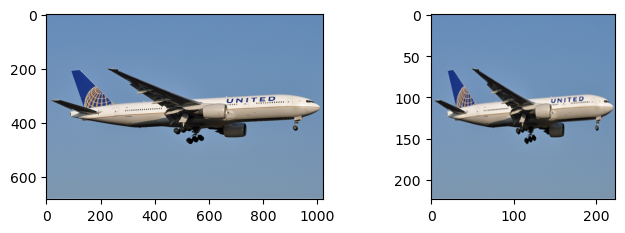

In [72]:
from PIL import Image

im = Image.open('./boeing.jpg')
width, height = im.size
plt.figure(figsize=(8, 2.4))
plt.subplot(1, 2, 1)
plt.imshow(im)
im = im.resize((224, 224))
plt.subplot(1, 2, 2)
plt.imshow(im)

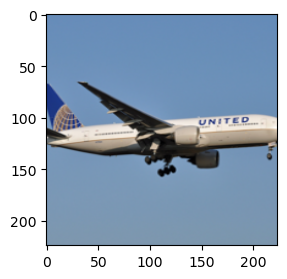

In [73]:
# Apply the augmentation using the transformation defined above.
# If you execute the cell again and again, you will see different
# result
plt.figure(figsize=(3, 3))
im_tensor = train_transform(im)
plt.imshow(convert_tensor_to_image(im_tensor))

In [74]:
output = model_A(im_tensor.unsqueeze(0))
print(f"output.shape = {output.shape}")

output.shape = torch.Size([1, 1000])


In [75]:
outputs = model_A(X_batch)
print(f"outputs.shape = {outputs.shape}")

outputs.shape = torch.Size([64, 1000])


## Finetune the ConvNet

As explained above, we now proceed with the first scenario in which we shall train the whole model.

### Modify the original *resnet18*

To perform transfer learning purpose, we need to adjust the original architecture of the ResNet18. Particularly, we are solving the binary classification and thus there are only two classes. Although, we can employ the binary cross-entropy as the loss function, we will use the cross-entropy loss function for multiclass problem. Again, we are concerned with only two classes. Therefore, the dimension of the logit ouputs is $2$. To this end, we modify the last fully connected layer in the **resnet18**.

In [16]:
fc_in_features = model_A.fc.in_features
fc_out_features = len(class_names) # or just = 2
model_A.fc = nn.Linear(in_features=fc_in_features, out_features=fc_out_features)
model_A = model_A.to(device)

Now, let us test the modified model on a batch of images. The output is suppoed to have the size $(N, 2)$ where $N$ is the batch size and $2$ stands for two logit output.

In [17]:
outputs = model_A(X_batch.to(device))
print(f"outputs.shape = {outputs.shape}")

outputs.shape = torch.Size([8, 2])


### Train the model

There is nothing fancy here. At the point you are reading this notebook, I assume that you have been quite familiar with writing a training loop for a neural network. Essentially, we need
- a model
- a dataloader for loading several minibatches per each epoch
- a loss function
- an optimizer

**What is more in the following code cell**

On top of these objects, here we introduce a learning rate scheduler (see [Learning Rate Scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LRScheduler.html#torch.optim.lr_scheduler.LRScheduler)). The  adjusts the learning rate during optimization. In this notebook, we shall use [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html). If you read the documentation, you will immediately understand the mechanism of the learning rate scheduler. The idea is rather simple: the learning rate is reduced after a certain number of epochs. This is to make sure the loss function does not overshoot in the training process. We, normally, don't want to have a very small learning rate as it makes the training slow. However, if we set the learning rate large, the loss function may overshoot after certain number of epochs. For this reason, it may be better to start with a reasonably large learning rate and reduce the learning rate after a pre-defined number of epochs.

For example, assume that we use the scheduler
```python
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
```
and the initial learning rate $\alpha = 0.05$. Then, the learning rate $\alpha$ will be modified according to the rule
$$
\begin{cases}
\alpha = 0.05 & \mathrm{epoch} < 30 \\[6pt]
\alpha = 0.005 & 30 \leq \mathrm{epoch} < 60 \\[6pt]
\alpha = 0.0005 & 60 \leq \mathrm{epoch} < 90 \\[6pt]
\text{so on}
\end{cases}
$$
Moreover, you will see that I use [Stochastic Gradient Descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) with the keyword argument `momentum=0.9`. As there is ton of knowledge in optimization theory and machine learning practice, please refer to offical documentation and the [Research Paper](http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf) to understand the meaning "*momentum*" in this algorithm.

In [18]:
# See the documentation to understand momentum keyword
optimizer = optim.SGD(model_A.parameters(), lr=0.001, momentum=0.9)      
criterion = nn.CrossEntropyLoss()
# The learning rate will be reduced by multiplier of 0.1 after every 7 epochs.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

<font style='color:magenta'>**Save the best model**  </font>

We shall use the validation set to measure the prediction power of the model. If the accuracy improves, we save the model parameters and continue the training. If it does not improve, we don't make any save. Therefore, the saved model parameters are the best parameters for making inference on the given validation set. The basic logic is that we hope that this set of parameters will be also equally good on the samples in real-world problem, outside the validation set.

**Remark**  
Since we will reuse the training process for the model in the second scenario "finetuning the ConvNet in the last layer*, we will wrap the following code for training process into a function. Of course, normally we don't need to do so.

In [ ]:
def train_model(model, path_to_state, criterion, optimizer, scheduler, epochs=30):
    my_file = Path(path_to_state)
    model.to(device)
    # torch.save(resnet18.state_dict(), file_name )
    if my_file.is_file():
        model.load_state_dict(torch.load(path_to_state, 
                                            weights_only=True))

    best_accuracy = 0.0
    EPOCHS = 30

    since = time.time()
    for epoch in range(EPOCHS):
        print(f"Epoch [{epoch}/{EPOCHS - 1}]")

        # Training phase:
        model.train()
        running_loss, running_corrects = 0.0, 0.0
        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                logits = model(X_batch)
                preds = torch.argmax(logits, dim=1)
                loss = criterion(logits, y_batch)

                loss.backward()
                optimizer.step()
                
            # Statistics
            running_loss += loss.item() * X_batch.shape[0]
            running_corrects += torch.sum(preds == y_batch.data)        # we can just use preds == y_batch

        epoch_loss = running_loss / train_dataset_size
        epoch_accuracy = running_corrects.double() / train_dataset_size
        print(f"Train loss: {epoch_loss:6.5f} -- Accuracy: {epoch_accuracy:5.4f}")

        exp_lr_scheduler.step()     # update the learning rate

        # Evaluation phase:
        model.eval()
        running_loss, running_corrects = 0.0, 0.0

        for X_batch, y_batch in valid_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.set_grad_enabled(False):
                logits = model(X_batch)
                preds = torch.argmax(logits, dim=1)
                loss = criterion(logits, y_batch)
            
            running_loss += loss.item() * X_batch.shape[0]
            running_corrects += torch.sum(preds == y_batch.data)     # no need for .data

        epoch_loss = running_loss / valid_dataset_size
        epoch_accuracy = running_corrects.double() / valid_dataset_size
        print(f"Valid loss: {epoch_loss:6.5f} -- Accuracy: {epoch_accuracy:5.4f}")
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            # Save the model
            torch.save(model.state_dict(), path_to_state)

        print(60*"=")

    telapsed = time.time() - since
    print(f"Training complete in {telapsed // 60:.0f} minutes {telapsed % 60:.0f} seconds")
    print(f"Best validiation accuracy: {best_accuracy}")

    return model

In [20]:
model_A = train_model(model_A, './best_ant_bee_model_A.pt', criterion, optimizer, exp_lr_scheduler, epochs=30)

Epoch [0/29]
Train loss: 0.69339 -- Accuracy: 0.5943


KeyboardInterrupt: 

**Visualize the model predictions**

The below function is a generic function to display predictions for a few images

In [ ]:
def visualize_result(model, nrows=2, ncols=4, num_images=8):
    was_training = model.training
    images_so_far = 0
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valid_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)

            # We need to put the images back to the cpu for showing
            inputs = inputs.cpu()
            for j in range(inputs.shape[0]):
                images_so_far += 1
                plt.subplot(nrows, ncols, images_so_far)

                plt.imshow(convert_tensor_to_image(inputs[j]))
                plt.axis('off')

                plt.title(f"predicted: {class_names[preds[j]]}")

                if images_so_far == num_images:
                    model_A.train(mode=was_training)                
                    return 
                
        model.train(mode=was_training)

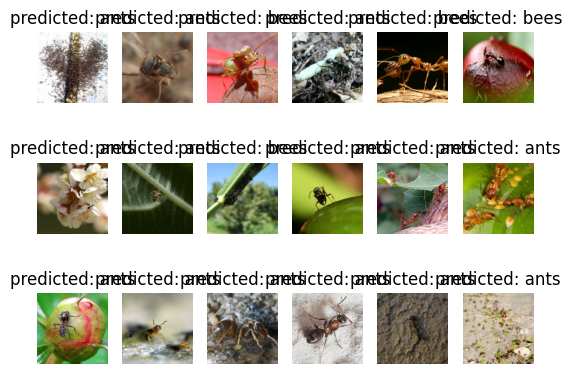

In [ ]:
visualize_result(model=model_A, nrows=3, ncols=6, num_images=18)

## ConvNet as fixed feature extractor

This is the second scenario in transfer learning. In particular, we need to freeze all the network except the final layer. We need to set `requires_grad=False` to freeze the parameters so that the gradients are not computed in `backward()`. To understand the mechanism under "*frozen-vs-unfrozen weight behavior*", you can read more about this in the documentation about [autograd mechanics](https://pytorch.org/docs/main/notes/autograd.html). If you run short of time, just ignore it for now and come back later.

In [ ]:
model_B = models.resnet18(weights='IMAGENET1K_V1')
for param in model_B.parameters():
    # So the computational graph does not need to keep track
    # of the gradient of any function (loss function for example) 
    # with respect to the model parameters.
    param.requires_grad_(False)     
    # or we can write
    # param.requires_grad = False

# Parameters of the newly defined modules have require_grad=True by default.
model_B.fc = nn.Linear(in_features=model_B.fc.in_features,
                          out_features=len(class_names))        # len(class_names) = 2 in the current example

model_B = model_B.to(device)        # put it cuda:0 -- this is possible on my local machine

criterion = nn.CrossEntropyLoss()

In [ ]:
# Again, we define the optimizer  and the learning rate scheduler.
# Note that learning rate scheduler is not necessary. But it is good for you to know
# and to learn it.
optimizer = optim.SGD(model_B.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=7, gamma=0.1)

### Train the model

This model should be trained faster than the last model as only the parameters in the last linear layer are updated. The entire code cell is almost identical to the code cell for trainining `model_A` is almost identical.

In [ ]:
model_B = train_model(model_B, './best_ant_bee_model_B.pt', criterion, optimizer, exp_lr_scheduler, epochs=30)

Epoch [0/29]
Train loss: 0.22101 -- Accuracy: 0.9180
Valid loss: 0.22735 -- Accuracy: 0.9346
Epoch [1/29]
Train loss: 0.27854 -- Accuracy: 0.8730
Valid loss: 0.22785 -- Accuracy: 0.9346
Epoch [2/29]
Train loss: 0.19880 -- Accuracy: 0.9426
Valid loss: 0.25139 -- Accuracy: 0.9281
Epoch [3/29]
Train loss: 0.37677 -- Accuracy: 0.8525
Valid loss: 0.22276 -- Accuracy: 0.9412
Epoch [4/29]
Train loss: 0.33936 -- Accuracy: 0.8484
Valid loss: 0.22491 -- Accuracy: 0.9281
Epoch [5/29]
Train loss: 0.35247 -- Accuracy: 0.8525
Valid loss: 0.32557 -- Accuracy: 0.8758
Epoch [6/29]
Train loss: 0.39909 -- Accuracy: 0.8156
Valid loss: 0.23575 -- Accuracy: 0.9346
Epoch [7/29]
Train loss: 0.26238 -- Accuracy: 0.9016
Valid loss: 0.22324 -- Accuracy: 0.9346
Epoch [8/29]
Train loss: 0.25658 -- Accuracy: 0.8648
Valid loss: 0.18994 -- Accuracy: 0.9412
Epoch [9/29]
Train loss: 0.25362 -- Accuracy: 0.8975
Valid loss: 0.18450 -- Accuracy: 0.9477
Epoch [10/29]
Train loss: 0.21131 -- Accuracy: 0.9098
Valid loss: 0.18

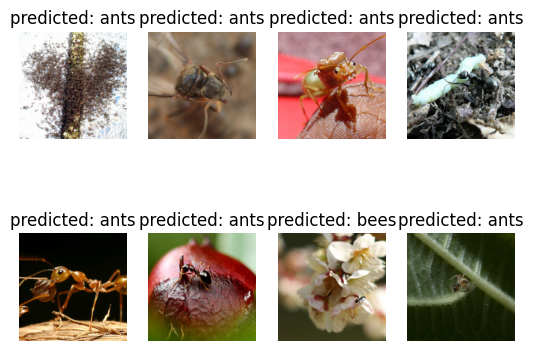

In [ ]:
# Visualize the images in the validation set
visualize_result(model_B)

### Inference on custom images

Use the trained model to make prediction on custom images and visualize the prediced class labels along with the images.

In [ ]:
def make_inference(model, image_path):
    was_training = model.training
    img = Image.open(image_path)
    img = valid_transform(img)
    img = img.unsqueeze(0)      # add the dimension for batch size
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        preds = torch.argmax(outputs, dim=1)

        img = convert_tensor_to_image(img.cpu().data[0])
        plt.imshow(img)
        plt.title(f"predicted: {class_names[preds[0]]}")
        model.train(mode=was_training)


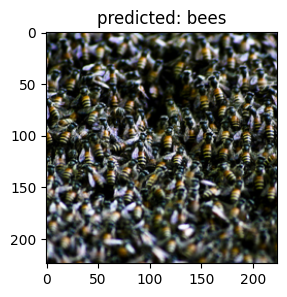

In [ ]:
plt.figure(figsize=(3, 3))
make_inference(model_B, image_path='./hymenoptera_data/val/bees/2709775832_85b4b50a57.jpg')